#  Importing Libraries

In [1]:
# pip install -U scikit-image

In [2]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K 
import random
import urllib.request
import matplotlib.image as mpimg

from skimage.filters import rank, threshold_otsu
from skimage import io
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from skimage.morphology import closing, square, disk

# Step 2 : Loading pictures and making Dictionary of images and labels

In [3]:
folder_benign_train = './archive/train/benign'
folder_malignant_train = './archive/train/malignant'

folder_benign_test = './archive/test/benign'
folder_malignant_test = './archive/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))


# Load in training Images

In [4]:
# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures

In [5]:
# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels

In [6]:
# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

In [7]:
print("The label for y_benign: \n",y_benign)
print("The label for y_malignant: \n",y_malignant)

The label for y_benign: 
 [0. 0. 0. ... 0. 0. 0.]
The label for y_malignant: 
 [1. 1. 1. ... 1. 1. 1.]


In [8]:
y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

print("the shape for y_benign_test ",y_benign_test.shape)
print("the shape for y_malignant_test ",y_malignant_test.shape)

the shape for y_benign_test  (360,)
the shape for y_malignant_test  (300,)


In [9]:
print("the shape for X_benign ",X_benign.shape)
print("the shape for X_malignant ",X_malignant.shape)
print("the shape for X_benign_test ",X_benign_test.shape)
print("the shape for X_malignant_test ",X_malignant_test.shape)

the shape for X_benign  (1440, 224, 224, 3)
the shape for X_malignant  (1197, 224, 224, 3)
the shape for X_benign_test  (360, 224, 224, 3)
the shape for X_malignant_test  (300, 224, 224, 3)


In [10]:
# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

In [11]:
print("the shape for X_train ",X_train.shape)

print("the shape for y_train ",y_train.shape)


the shape for X_train  (2637, 224, 224, 3)
the shape for y_train  (2637,)


In [12]:
X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)


In [13]:
print("the shape for X_test ",X_test.shape)

print("the shape for y_test ",y_test.shape)

the shape for X_test  (660, 224, 224, 3)
the shape for y_test  (660,)


In [14]:
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

In [15]:
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

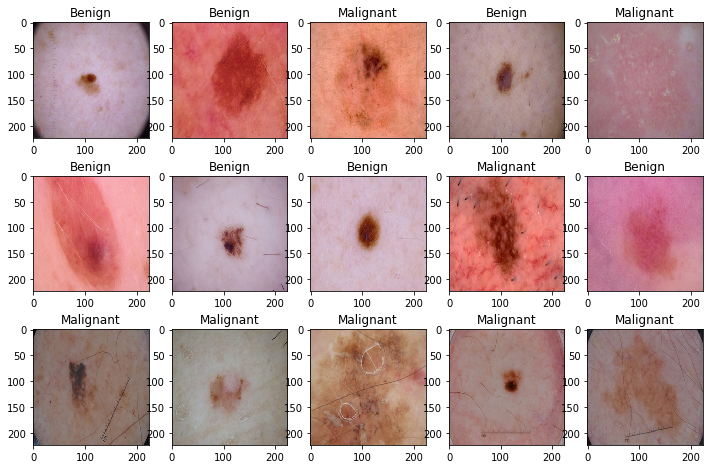

In [16]:
# Display first 15 images of moles, and how they are classified
w=40
h=40
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Categorical Labels

In [17]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [18]:
print("the shape:",y_train.shape)
print("the shape:",y_test.shape)

the shape: (2637, 2)
the shape: (660, 2)


In [19]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

In [20]:
print("the shape for X_train ",X_train.shape)

print("the shape for y_train ",X_test.shape)

the shape for X_train  (2637, 224, 224, 3)
the shape for y_train  (660, 224, 224, 3)


# Bulding the Model

In [21]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Dense, Activation, SimpleRNN
from tensorflow.keras.layers import Flatten, concatenate
from PIL import Image as Img

In [22]:
image_size = X_train.shape[1]
image_size

224

In [23]:
# compute the number of labels
num_labels = len(np.unique(y_train))
print("Number Of Labels:",num_labels)

Number Of Labels: 2


In [24]:
# network parameters
# image is processed as is (square grayscale)
input_shape = (image_size, image_size, 3)
batch_size = 128
kernel_size = 3
pool_size = 2
filters = 64
dropout = 0.2

In [25]:
# model is a stack of CNN-ReLU-MaxPooling
model = Sequential()

model.add(Conv2D(filters=filters,
        kernel_size=kernel_size,
        activation='relu',
        input_shape=input_shape))

model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters, kernel_size=kernel_size,
        activation='relu'))

model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters,
        kernel_size=kernel_size,
        activation='relu'))

model.add(Flatten())
# dropout added as regularizer
model.add(Dropout(dropout))
# output layer is 10-dim one-hot vector
model.add(Dense(num_labels))
model.add(Activation('softmax'))


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

In [27]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='cnn-mnist.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [28]:
# loss function for one-hot vector
# use of adam optimizer
# accuracy is good metric for classification tasks
model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

In [29]:
# train the network
history =model.fit(X_train, y_train, epochs=50, batch_size=batch_size)

Epoch 1/50
21/21 [==============================] - 148s 5s/step - loss: 1.3998 - accuracy: 0.5487
Epoch 2/50
21/21 [==============================] - 114s 5s/step - loss: 0.5693 - accuracy: 0.6989
Epoch 3/50
21/21 [==============================] - 175s 8s/step - loss: 0.5615 - accuracy: 0.7148
Epoch 4/50
21/21 [==============================] - 127s 6s/step - loss: 0.4783 - accuracy: 0.7543
Epoch 5/50
21/21 [==============================] - 127s 6s/step - loss: 0.4652 - accuracy: 0.7630
Epoch 6/50
21/21 [==============================] - 123s 6s/step - loss: 0.4148 - accuracy: 0.7884
Epoch 7/50
21/21 [==============================] - 126s 6s/step - loss: 0.4005 - accuracy: 0.7964
Epoch 8/50
21/21 [==============================] - 125s 6s/step - loss: 0.3866 - accuracy: 0.8051
Epoch 9/50
21/21 [==============================] - 130s 6s/step - loss: 0.3856 - accuracy: 0.8085
Epoch 10/50
21/21 [==============================] - 125s 6s/step - loss: 0.3694 - accuracy: 0.8123
Epoch 11/

dict_keys(['loss', 'accuracy'])


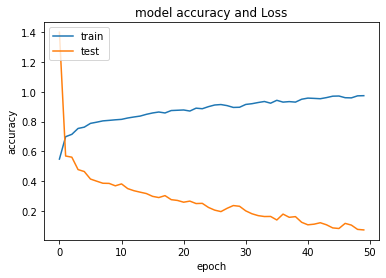

In [30]:
                   
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy and Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
model.save('h5')

INFO:tensorflow:Assets written to: h5\assets


INFO:tensorflow:Assets written to: h5\assets


In [32]:
prediction=model.predict(X_test)

21/21 [==============================] - 5s 235ms/step


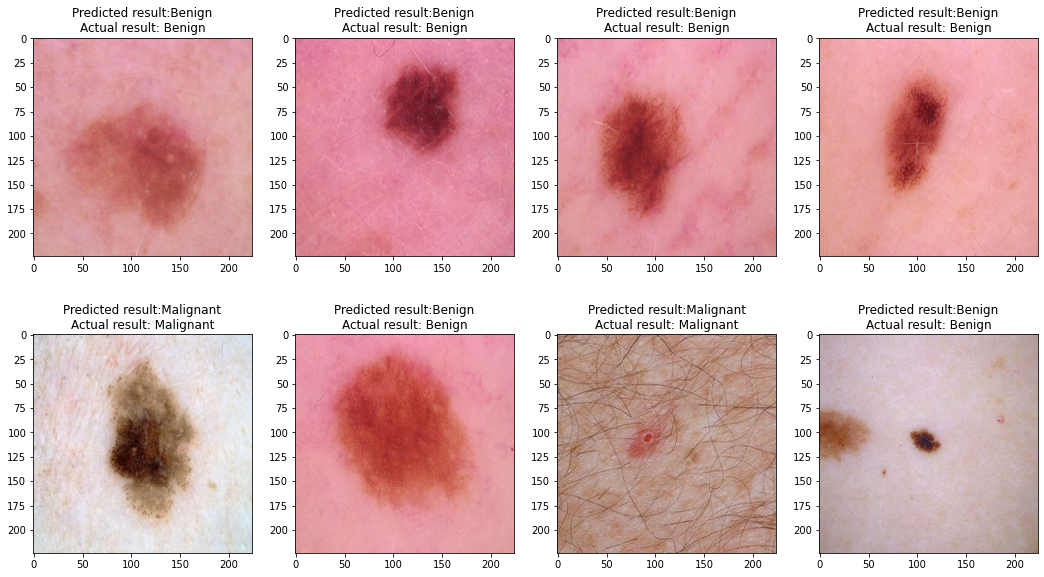

In [33]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==np.argmax(prediction[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==np.argmax(prediction[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(prediction[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()


# Using MobileNetV2


In [34]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [35]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [36]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 32

model = MobileNetV2(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling=None,
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])




In [37]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [38]:
plot_model(model, to_file='cnn-skin.jpg', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [39]:
history2 = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )

Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.7233 - accuracy: 0.5548WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 160s 2s/step - loss: 0.7233 - accuracy: 0.5548 - val_loss: 0.6926 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.6772 - accuracy: 0.5747WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 150s 2s/step - loss: 0.6772 - accuracy: 0.5747 - val_loss: 0.6921 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.6292 - accuracy: 0.6041WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 149s 2s/step - loss: 0.6292 - accuracy: 0.6041 - val_loss: 0.6915 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.5582 - accuracy: 0.7103WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 148s 2s/step - loss: 0.5582 - accuracy: 0.7103 - val_loss: 0.6909 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 5/50
66/66 [==============================] - ETA: 0s - loss: 0.5041 - accuracy: 0.7544WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 147s 2s/step - loss: 0.5041 - accuracy: 0.7544 - val_loss: 0.6906 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 6/50
66/66 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.7643WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 147s 2s/step - loss: 0.4839 - accuracy: 0.7643 - val_loss: 0.6908 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 7/50
66/66 [==============================] - ETA: 0s - loss: 0.4575 - accuracy: 0.7828WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 145s 2s/step - loss: 0.4575 - accuracy: 0.7828 - val_loss: 0.6915 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 8/50
66/66 [==============================] - ETA: 0s - loss: 0.4577 - accuracy: 0.7743WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 145s 2s/step - loss: 0.4577 - accuracy: 0.7743 - val_loss: 0.6927 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 9/50
66/66 [==============================] - ETA: 0s - loss: 0.4517 - accuracy: 0.7752WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 145s 2s/step - loss: 0.4517 - accuracy: 0.7752 - val_loss: 0.6943 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 10/50
66/66 [==============================] - ETA: 0s - loss: 0.4328 - accuracy: 0.7961WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 148s 2s/step - loss: 0.4328 - accuracy: 0.7961 - val_loss: 0.6972 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 11/50
66/66 [==============================] - ETA: 0s - loss: 0.4378 - accuracy: 0.7819WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 146s 2s/step - loss: 0.4378 - accuracy: 0.7819 - val_loss: 0.7001 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 12/50
66/66 [==============================] - ETA: 0s - loss: 0.4164 - accuracy: 0.8018WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 146s 2s/step - loss: 0.4164 - accuracy: 0.8018 - val_loss: 0.7038 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 13/50
66/66 [==============================] - ETA: 0s - loss: 0.4228 - accuracy: 0.7923WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 145s 2s/step - loss: 0.4228 - accuracy: 0.7923 - val_loss: 0.7080 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 14/50
66/66 [==============================] - ETA: 0s - loss: 0.4171 - accuracy: 0.7942WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 149s 2s/step - loss: 0.4171 - accuracy: 0.7942 - val_loss: 0.7134 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 15/50
66/66 [==============================] - ETA: 0s - loss: 0.4006 - accuracy: 0.8146WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 146s 2s/step - loss: 0.4006 - accuracy: 0.8146 - val_loss: 0.7184 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 16/50
66/66 [==============================] - ETA: 0s - loss: 0.4036 - accuracy: 0.8056WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 147s 2s/step - loss: 0.4036 - accuracy: 0.8056 - val_loss: 0.7250 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 17/50
66/66 [==============================] - ETA: 0s - loss: 0.4014 - accuracy: 0.8084WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 147s 2s/step - loss: 0.4014 - accuracy: 0.8084 - val_loss: 0.7311 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 18/50
66/66 [==============================] - ETA: 0s - loss: 0.3873 - accuracy: 0.8094WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 146s 2s/step - loss: 0.3873 - accuracy: 0.8094 - val_loss: 0.7396 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 19/50
66/66 [==============================] - ETA: 0s - loss: 0.3867 - accuracy: 0.8160WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 147s 2s/step - loss: 0.3867 - accuracy: 0.8160 - val_loss: 0.7454 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 20/50
66/66 [==============================] - ETA: 0s - loss: 0.3853 - accuracy: 0.8122WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 147s 2s/step - loss: 0.3853 - accuracy: 0.8122 - val_loss: 0.7556 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 21/50
66/66 [==============================] - ETA: 0s - loss: 0.3851 - accuracy: 0.8070WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 203s 3s/step - loss: 0.3851 - accuracy: 0.8070 - val_loss: 0.7652 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 22/50
66/66 [==============================] - ETA: 0s - loss: 0.3732 - accuracy: 0.8118WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 174s 3s/step - loss: 0.3732 - accuracy: 0.8118 - val_loss: 0.7769 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 23/50
66/66 [==============================] - ETA: 0s - loss: 0.3726 - accuracy: 0.8198WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 177s 3s/step - loss: 0.3726 - accuracy: 0.8198 - val_loss: 0.7846 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 24/50
66/66 [==============================] - ETA: 0s - loss: 0.3663 - accuracy: 0.8260WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 174s 3s/step - loss: 0.3663 - accuracy: 0.8260 - val_loss: 0.7969 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 25/50
66/66 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.8331WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 172s 3s/step - loss: 0.3613 - accuracy: 0.8331 - val_loss: 0.8103 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 26/50
66/66 [==============================] - ETA: 0s - loss: 0.3625 - accuracy: 0.8250WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 174s 3s/step - loss: 0.3625 - accuracy: 0.8250 - val_loss: 0.8162 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 27/50
66/66 [==============================] - ETA: 0s - loss: 0.3443 - accuracy: 0.8468WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 174s 3s/step - loss: 0.3443 - accuracy: 0.8468 - val_loss: 0.8357 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 28/50
66/66 [==============================] - ETA: 0s - loss: 0.3510 - accuracy: 0.8312WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 172s 3s/step - loss: 0.3510 - accuracy: 0.8312 - val_loss: 0.8478 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 29/50
66/66 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.8454WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 173s 3s/step - loss: 0.3425 - accuracy: 0.8454 - val_loss: 0.8641 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 30/50
66/66 [==============================] - ETA: 0s - loss: 0.3261 - accuracy: 0.8521WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 173s 3s/step - loss: 0.3261 - accuracy: 0.8521 - val_loss: 0.8866 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 31/50
66/66 [==============================] - ETA: 0s - loss: 0.3343 - accuracy: 0.8402WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 172s 3s/step - loss: 0.3343 - accuracy: 0.8402 - val_loss: 0.9020 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 32/50
66/66 [==============================] - ETA: 0s - loss: 0.3339 - accuracy: 0.8487WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 173s 3s/step - loss: 0.3339 - accuracy: 0.8487 - val_loss: 0.9233 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 33/50
66/66 [==============================] - ETA: 0s - loss: 0.3201 - accuracy: 0.8549WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 173s 3s/step - loss: 0.3201 - accuracy: 0.8549 - val_loss: 0.9354 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 34/50
66/66 [==============================] - ETA: 0s - loss: 0.3141 - accuracy: 0.8544WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 161s 2s/step - loss: 0.3141 - accuracy: 0.8544 - val_loss: 0.9561 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 35/50
66/66 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8450WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 148s 2s/step - loss: 0.3304 - accuracy: 0.8450 - val_loss: 0.9692 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 36/50
66/66 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.8630WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 152s 2s/step - loss: 0.3002 - accuracy: 0.8630 - val_loss: 0.9925 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 37/50
66/66 [==============================] - ETA: 0s - loss: 0.3039 - accuracy: 0.8677WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 149s 2s/step - loss: 0.3039 - accuracy: 0.8677 - val_loss: 1.0238 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 38/50
66/66 [==============================] - ETA: 0s - loss: 0.3011 - accuracy: 0.8596WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 147s 2s/step - loss: 0.3011 - accuracy: 0.8596 - val_loss: 1.0358 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 39/50
66/66 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.8511WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 145s 2s/step - loss: 0.3178 - accuracy: 0.8511 - val_loss: 1.0576 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 40/50
66/66 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.8644WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 145s 2s/step - loss: 0.2990 - accuracy: 0.8644 - val_loss: 1.0808 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 41/50
66/66 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.8634WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 146s 2s/step - loss: 0.2968 - accuracy: 0.8634 - val_loss: 1.0908 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 42/50
66/66 [==============================] - ETA: 0s - loss: 0.2967 - accuracy: 0.8615WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 148s 2s/step - loss: 0.2967 - accuracy: 0.8615 - val_loss: 1.1221 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 43/50
66/66 [==============================] - ETA: 0s - loss: 0.2941 - accuracy: 0.8672WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 146s 2s/step - loss: 0.2941 - accuracy: 0.8672 - val_loss: 1.1565 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 44/50
66/66 [==============================] - ETA: 0s - loss: 0.2894 - accuracy: 0.8687WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 147s 2s/step - loss: 0.2894 - accuracy: 0.8687 - val_loss: 1.1771 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 45/50
66/66 [==============================] - ETA: 0s - loss: 0.2762 - accuracy: 0.8753WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 147s 2s/step - loss: 0.2762 - accuracy: 0.8753 - val_loss: 1.2058 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 46/50
66/66 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.8829WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 147s 2s/step - loss: 0.2767 - accuracy: 0.8829 - val_loss: 1.2168 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 47/50
66/66 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.8848WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 147s 2s/step - loss: 0.2607 - accuracy: 0.8848 - val_loss: 1.2547 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 48/50
66/66 [==============================] - ETA: 0s - loss: 0.2677 - accuracy: 0.8810WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 147s 2s/step - loss: 0.2677 - accuracy: 0.8810 - val_loss: 1.2868 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 49/50
66/66 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.8781WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 147s 2s/step - loss: 0.2733 - accuracy: 0.8781 - val_loss: 1.3065 - val_accuracy: 0.5360 - lr: 1.0000e-05
Epoch 50/50
66/66 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.8772WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


66/66 [==============================] - 147s 2s/step - loss: 0.2691 - accuracy: 0.8772 - val_loss: 1.3327 - val_accuracy: 0.5360 - lr: 1.0000e-05


In [40]:
model.save('h1')

INFO:tensorflow:Assets written to: h1\assets


INFO:tensorflow:Assets written to: h1\assets


<AxesSubplot:>

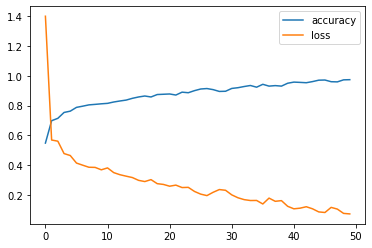

In [41]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'loss']].plot()

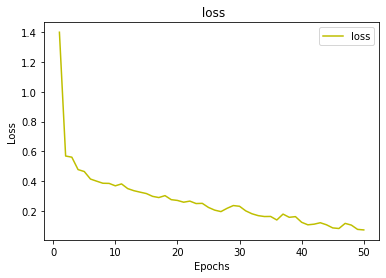

In [42]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='loss')
plt.title(' loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
pred = model.predict(X_test)#Reconstruction of Test Images

21/21 [==============================] - 9s 384ms/step


# For MobileNet

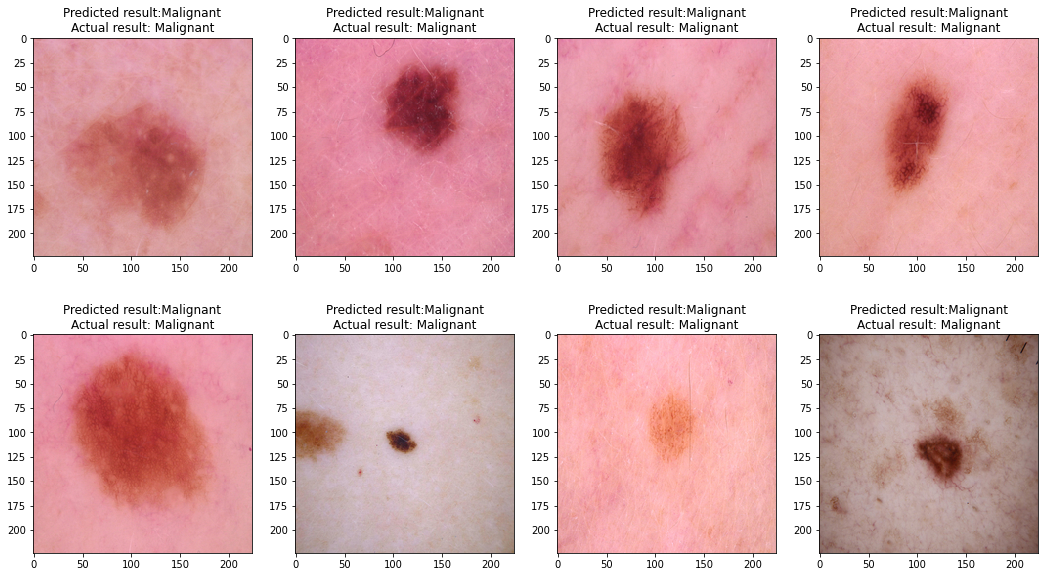

In [44]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==np.argmax(pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==np.argmax(pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==1:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()


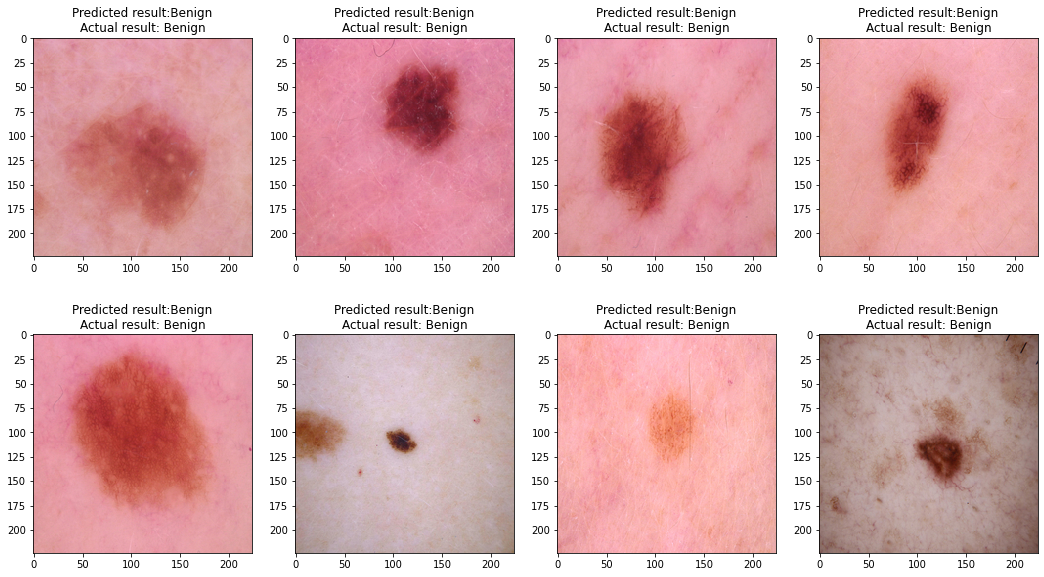

In [45]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==np.argmax(pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==np.argmax(pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()


In [48]:
new_model = keras.models.load_model('h1')

In [49]:
pred = new_model.predict(X_test)

21/21 [==============================] - 9s 383ms/step


In [50]:
pred

array([[0.995812  , 0.00418797],
       [0.9958112 , 0.00418875],
       [0.99581194, 0.00418809],
       ...,
       [0.9958121 , 0.0041878 ],
       [0.99581224, 0.00418775],
       [0.9958117 , 0.00418835]], dtype=float32)

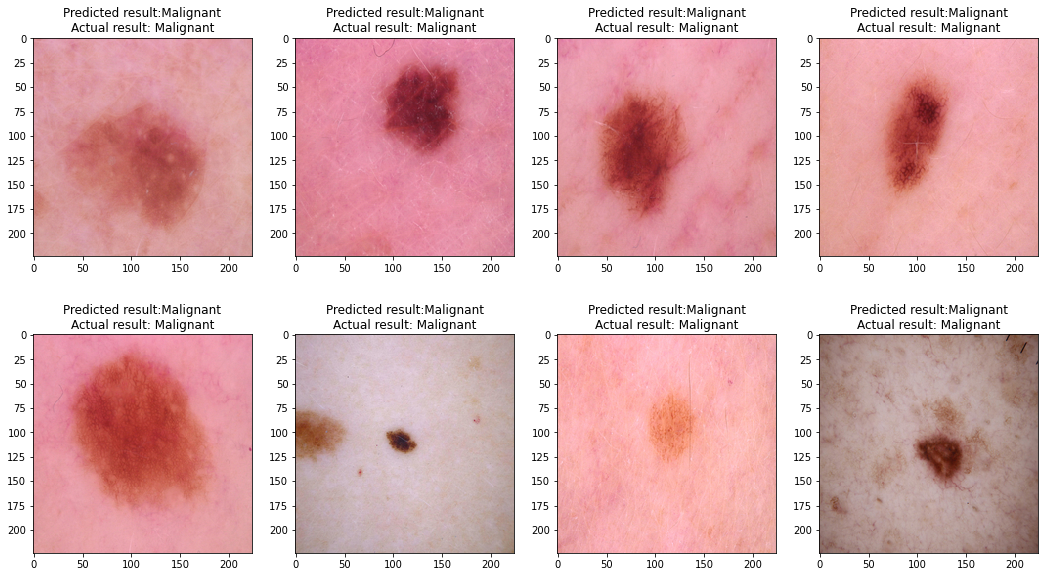

In [51]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==np.argmax(pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==np.argmax(pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==1:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()